In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV


In [2]:
### Importing the 20newsgroup training data

#Loading the data set - training data.
from sklearn.datasets import fetch_20newsgroups
# mydata_train = fetch_20newsgroups(subset='train', shuffle=True)
mydata_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers', 'quotes'))

print('Training data size:', len(mydata_train['data']))

len(mydata_train['target'])


Training data size: 11314


11314

In [3]:
# Printing all the categories
mydata_train.target_names 

# Finding frequency of each category
targets, frequency = np.unique(mydata_train.target, return_counts=True)
targets, frequency 

targets_str = np.array(mydata_train.target_names)
print(list(zip(targets_str, frequency)))

[('alt.atheism', 480), ('comp.graphics', 584), ('comp.os.ms-windows.misc', 591), ('comp.sys.ibm.pc.hardware', 590), ('comp.sys.mac.hardware', 578), ('comp.windows.x', 593), ('misc.forsale', 585), ('rec.autos', 594), ('rec.motorcycles', 598), ('rec.sport.baseball', 597), ('rec.sport.hockey', 600), ('sci.crypt', 595), ('sci.electronics', 591), ('sci.med', 594), ('sci.space', 593), ('soc.religion.christian', 599), ('talk.politics.guns', 546), ('talk.politics.mideast', 564), ('talk.politics.misc', 465), ('talk.religion.misc', 377)]


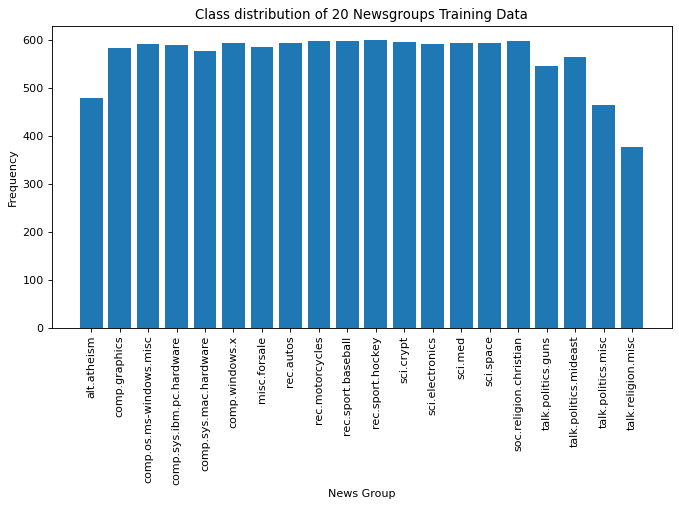

In [4]:
# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_str,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

In [5]:
### Importing the 20newsgroup test data 

# mydata_test = fetch_20newsgroups(subset='test', shuffle=True)
mydata_test = fetch_20newsgroups(subset='test', shuffle=True, remove = ('headers', 'footers', 'quotes'))

print('Testing data size:', len(mydata_test['data']))

Testing data size: 7532


In [6]:
# Finding frequency of each category
targets_test, frequency_test = np.unique(mydata_test.target, return_counts=True)
targets_test_str = np.array(mydata_test.target_names)
print(list(zip(targets_test_str, frequency_test)))

[('alt.atheism', 319), ('comp.graphics', 389), ('comp.os.ms-windows.misc', 394), ('comp.sys.ibm.pc.hardware', 392), ('comp.sys.mac.hardware', 385), ('comp.windows.x', 395), ('misc.forsale', 390), ('rec.autos', 396), ('rec.motorcycles', 398), ('rec.sport.baseball', 397), ('rec.sport.hockey', 399), ('sci.crypt', 396), ('sci.electronics', 393), ('sci.med', 396), ('sci.space', 394), ('soc.religion.christian', 398), ('talk.politics.guns', 364), ('talk.politics.mideast', 376), ('talk.politics.misc', 310), ('talk.religion.misc', 251)]


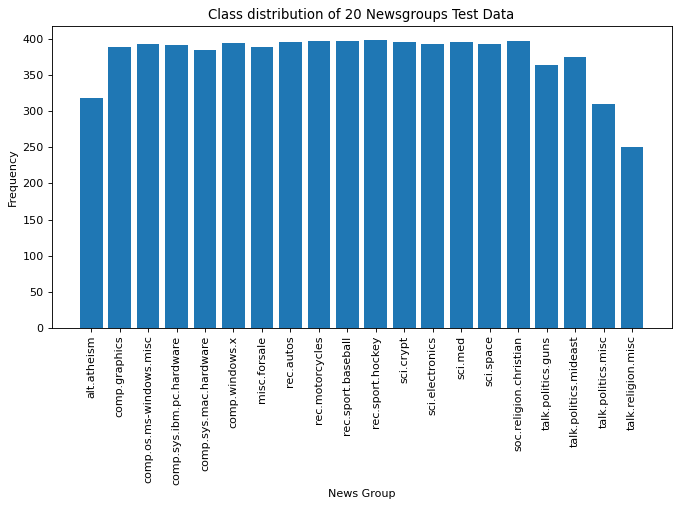

In [7]:
# Testing data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_test_str,frequency_test)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Test Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()


In [10]:
### Data Preparation: 

mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})
mydata_train_df.head()

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [11]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

mydata_train_df['data'] = mydata_train_df.data.map(alphanumeric).map(punc_lower)
mydata_train_df.head()

,data,target
0,i was wondering if anyone out there could enli...,7
1,a fair number of brave souls who upgraded thei...,4
2,well folks my mac plus finally gave up the gh...,4
3,\ndo you have weitek s address phone number ...,1
4,from article world std com by tombaker ...,14


In [12]:
# Preparing test data
mydata_test_df = pd.DataFrame({'data': mydata_test.data, 'target': mydata_test.target})
mydata_test_df.head()

,data,target
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [13]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

mydata_test_df['data'] = mydata_test_df.data.map(alphanumeric).map(punc_lower)
mydata_test_df.head()

,data,target
0,i am a little confused on all of the models of...,7
1,i m not familiar at all with the format of the...,5
2,\nin a word yes \n,0
3,\nthey were attacking the iraqis to drive them...,17
4,\ni ve just spent two solid months arguing tha...,19


In [14]:
### Count Vectorizer

# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')

X_train_cv = count_vect.fit_transform(mydata_train_df.data)  # fit_transform learns the vocab and one-hot encodes
X_test_cv = count_vect.transform(mydata_test_df.data) # transform uses the same vocab and one-hot encodes

print(X_train_cv.shape)
print(type(X_train_cv))


X_train_cv_df = pd.DataFrame(X_train_cv.todense())
X_train_cv_df.columns = sorted(count_vect.vocabulary_)
X_train_cv_df.head()

(11314, 67822)
<class 'scipy.sparse.csr.csr_matrix'>


,aa,aaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaah,aaahh,aaahhhh,aaai,aacc,aachen,...,zznkjz,zznkzz,zznp,zzrk,zzz,zzzoh,zzzzzz,zzzzzzt,³ation,ýé
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
### TF-IDF Vectorizer

# Creating a document-term matrix using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfV = TfidfVectorizer(stop_words='english') 
# tfidfV = TfidfVectorizer(ngram_range=(1, 2), binary =True, stop_words='english') 

X_train_tfidfV = tfidfV.fit_transform(mydata_train_df.data) # fit_transform learns the vocab and one-hot encodes 
X_test_tfidfV = tfidfV.transform(mydata_test_df.data) # transform uses the same vocab and one-hot encodes 


In [16]:
# print the dimensions of the training set (text messages, terms) 
print(X_train_tfidfV.shape)
print(type(X_train_tfidfV))


X_train_tfidfV_df = pd.DataFrame(X_train_tfidfV.todense())
X_train_tfidfV_df.columns = sorted(tfidfV.vocabulary_)
X_train_tfidfV_df.head()

(11314, 67822)
<class 'scipy.sparse.csr.csr_matrix'>


,aa,aaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaah,aaahh,aaahhhh,aaai,aacc,aachen,...,zznkjz,zznkzz,zznp,zzrk,zzz,zzzoh,zzzzzz,zzzzzzt,³ation,ýé
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
### Classification Models

# Use a Naive Bayes model 
from sklearn.naive_bayes import MultinomialNB 

mnb = MultinomialNB() 

# Train the model 
y_train = mydata_train_df.target
mnb.fit(X_train_cv, y_train) 

# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data 
y_pred_cv_mnb = mnb.predict(X_test_cv) 
y_pred_cv_mnb # The output is all of the predictions


from sklearn.metrics import classification_report, accuracy_score

y_test = mydata_test_df.target
print(accuracy_score(y_test, y_pred_cv_mnb))
print(classification_report(y_test, y_pred_cv_mnb))

0.6399362719065321
              precision    recall  f1-score   support

           0       0.60      0.36      0.45       319
           1       0.57      0.70      0.63       389
           2       0.67      0.01      0.02       394
           3       0.50      0.71      0.58       392
           4       0.72      0.58      0.64       385
           5       0.58      0.80      0.67       395
           6       0.85      0.66      0.75       390
           7       0.82      0.70      0.76       396
           8       0.90      0.65      0.75       398
           9       0.93      0.76      0.84       397
          10       0.58      0.92      0.71       399
          11       0.58      0.78      0.66       396
          12       0.67      0.49      0.57       393
          13       0.83      0.79      0.81       396
          14       0.76      0.75      0.76       394
          15       0.48      0.90      0.63       398
          16       0.55      0.65      0.60       364
        

In [18]:
## Using pipeline now onwards to do the modeling

### 1. Using Multinominal Naive Bayes Model

# Performance of NB Classifier with No Stemming & Lemmatization
text_clf = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', MultinomialNB())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

0.6692777482740307


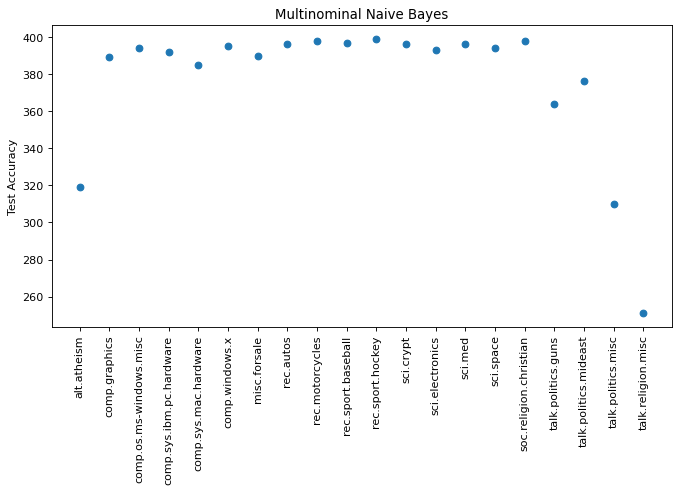

In [20]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(targets_test_str,frequency_test)
plt.xticks(rotation=90)
plt.title('Multinominal Naive Bayes')
plt.ylabel('Test Accuracy')
plt.show()

In [ ]:
### 2. Using Logistic Regression Model

# Performance of LR Classifier with No Stemming & Lemmatization
text_clf = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))

In [ ]:
# Performing Grid Search to find best LR parameters
pipeline = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # MultinomialNB, LogisticRegression, SGDClassifier

parameters = {
       'clf__penalty': ('l1', 'l2')
}

grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(mydata_train_df.data, mydata_train_df.target)

In [ ]:
# grid_search.cv_results_
print('Best training score %0.4f' % grid_search.best_score_)

print('Best parameters = ')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


In [ ]:
# Test Accuracy
grid_search.best_estimator_.score(mydata_test_df.data, mydata_test_df.target)

In [ ]:
### 3. Using Stochastic Gradient Descent Classifier Model

# Performance of SGD Classifier with No Stemming & Lemmatization
random.seed(1)
text_clf = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', SGDClassifier())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))

In [ ]:
### 4. Using k Nearest Neighbors Model

# Performance of kNN Classifier with No Stemming & Lemmatization
text_clf = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier(n_neighbors=100))])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
# grid_search.cv_results_
print('Best training score %0.4f' % grid_search.best_score_)

print('Best parameters = ')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
 # Test Accuracy
grid_search.best_estimator_.score(mydata_test_df.data, mydata_test_df.target)

In [ ]:
### Using Stemming
## 1. Terms in TF-IDF Vectorizer are unigrams (single words)
## First we will apply stemming to extract only unigrams from the text data to form the vectorizer.

stemmer = SnowballStemmer('english', ignore_stopwords=True)

class StemmedTfidfVectorizer(TfidfVectorizer):
    
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedTfidfVectorizer, self).__init__(*args, **kwargs)
        self.stemmer = stemmer
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (self.stemmer.stem(word) for word in analyzer(doc.replace('\n', ' ')))

In [ ]:
 ### 1.1. Using Multinominal Naive Bayes Model

# Performance of NB Classifier with Stemming
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', MultinomialNB())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 1.2. Using Logistic Regression Model

# Performance of LR Classifier with Stemming
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 1.3. Using Stochastic Gradient Descent Classifier Model

# Performance of SGD Classifier with Stemming
random.seed(1)
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', SGDClassifier())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 1.4. Using k Nearest Neighbors Model

# Performance of kNN Classifier with Stemming
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance'))])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))


In [ ]:
### 2. Terms in TF-IDF Vectorizer are unigrams and bigrams, and values are binary values
## Now we will extract unigrams as well as bigrams from the text to form the TF-IDF vectorizer.

### 2.1. Using Multinominal Naive Bayes Model

# Performance of NB Classifier with Stemming, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', MultinomialNB())])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))


In [ ]:
### 2.2. Using Logistic Regression Model

# Performance of LR Classifier with Stemming, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 2.3. Using Stochastic Gradient Descent Classifier Model

%%time
random.seed(1)
# Performance of SGD Classifier with Stemming, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', SGDClassifier())])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 2.4. Using k Nearest Neighbors Model

# Performance of KNN Classifier with Stemming, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', StemmedTfidfVectorizer(stemmer=stemmer, stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance'))])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 3. Using Lemmatization

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [ ]:
### 3.1. Using Multinominal Naive Bayes Model

# Performance of NB Classifier with Lemmatization
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', MultinomialNB())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))


In [ ]:
### 3.2. Using Logistic Regression Model

# Performance of LR Classifier with Lemmatization
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
# Performing Grid Search to find best LR parameters
pipeline = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # MultinomialNB, LogisticRegression, SGDClassifier

parameters = {
       'clf__penalty': ('l1', 'l2')
}

grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(mydata_train_df.data, mydata_train_df.target)

In [ ]:
# grid_search.cv_results_
print('Best training score %0.4f' % grid_search.best_score_)

print('Best parameters = ')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Test Accuracy
grid_search.best_estimator_.score(mydata_test_df.data, mydata_test_df.target)

In [ ]:
### 3.3. Using Stochastic Gradient Descent Classifier Model

# Performance of SGD Classifier with Lemmatization
random.seed(1)
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', SGDClassifier())])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 3.4. Using k Nearest Neighbors Model

# Performance of kNN Classifier with Lemmatization
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier(n_neighbors=100))])  # MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
# Performing Grid Search to find best kNN parameters
pipeline = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier())])  # MultinomialNB, LogisticRegression, SGDClassifier

parameters = {
       'clf__n_neighbors': (5, 10, 100, 200),
       'clf__weights': ('uniform', 'distance')
}

grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(mydata_train_df.data, mydata_train_df.target)

In [ ]:
# grid_search.cv_results_
print('Best training score %0.4f' % grid_search.best_score_)

In [ ]:
# Test Accuracy
grid_search.best_estimator_.score(mydata_test_df.data, mydata_test_df.target)

In [ ]:
## Now we will extract unigrams as well as bigrams from the text to form the TF-IDF vectorizer.

### 4.1. Using Multinominal Naive Bayes Model

# Performance of NB Classifier with Lemmatization, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', MultinomialNB())])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 4.2. Using Logistic Regression Model

# Performance of LR Classifier with Lemmatization, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
# Performing Grid Search to find best LR parameters
pipeline = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', LogisticRegression())])  # MultinomialNB, LogisticRegression, SGDClassifier

parameters = {
       'clf__penalty': ('l1', 'l2')
}

grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(mydata_train_df.data, mydata_train_df.target)

In [ ]:
# grid_search.cv_results_
print('Best training score %0.4f' % grid_search.best_score_)

print('Best parameters = ')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Test Accuracy
grid_search.best_estimator_.score(mydata_test_df.data, mydata_test_df.target)

In [ ]:
### 4.3. Using Stochastic Gradient Descent Classifier Model

random.seed(1)
# Performance of SGD Classifier with Lemmatization, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', SGDClassifier())])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
### 4.4. Using k Nearest Neighbors Model

# Performance of KNN Classifier with Lemmatization, and ngram_range = (1,2)
text_clf = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier(n_neighbors=100))])  # BernoulliNB, MultinomialNB, LogisticRegression, SGDClassifier, KNeighborsClassifier

text_clf.fit(mydata_train_df.data, mydata_train_df.target)
print(text_clf.score(mydata_test_df.data, mydata_test_df.target))
# print(classification_report(mydata_test_df.target, text_clf.predict(mydata_test_df.data)))

In [ ]:
# Performing Grid Search to find best kNN parameters
pipeline = Pipeline([
        ('vect', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range = (1,2), binary = True, sublinear_tf=True)), # CountVectorizer, TfidfVectorizer
        ('clf', KNeighborsClassifier())])  # MultinomialNB, LogisticRegression, SGDClassifier

parameters = {
       'clf__n_neighbors': (5, 10, 100, 200),
       'clf__weights': ('uniform', 'distance')
}

grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(mydata_train_df.data, mydata_train_df.target)

In [ ]:
# grid_search.cv_results_
print('Best training score %0.4f' % grid_search.best_score_)

print('Best parameters = ')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Test Accuracy
grid_search.best_estimator_.score(mydata_test_df.data, mydata_test_df.target)